In [1]:
import pandas as pd
import nltk
import torch.nn as nn
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from matplotlib import pyplot as plt



In [2]:

# Replace 'your_file.csv' with the actual path to your CSV file
file_path_train = 'data/train.csv'
file_path_test = 'data/test.csv'

# Read the CSV file into a DataFrame
df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

In [3]:
df_test.head()

,topic,hashtag,content,hashtag_related 1,hashtag_related 2,hashtag_related 3,hashtag_related 4,hashtag_related 5,author,create_at
0,Lifestyle,Lifehack,beauty lifehack save on makeup remover us...,#lifehack,NaN,NaN,NaN,NaN,martinenyx,2023-11-13 00:44:13+00:00
1,News,BreakingNews,reuters ukraine says russians intensify bomb...,#WNN7,#WorldNewsNuggets,NaN,NaN,NaN,WNN7,2023-11-14 02:09:09.048000+00:00
2,Technology,Technology,the residency imagining robots at waag futurel...,#eudigitaldeal,#opencall,#creativeeurope,#artistresidencies,#ai,waag,2023-11-14 12:07:06+00:00
3,Travel,Tourism,tal grazzja 🇲🇹 malta 2006 📷shot © bianca...,#autobus,#bus,#transports,#malta,#europe,salvomic,2023-11-13 16:40:38+00:00
4,Environment,Nature,green snake on a tree branch photography n...,#photography,#nature,#naturephotography,#wildlife,#snake,PatrickReedPhotography,2023-11-14 15:31:36.584000+00:00


In [4]:
print("Number of training examples: ", df_train.shape[0])
print("Number of testing examples: ", df_test.shape[0])

Number of training examples:  2088
Number of testing examples:  523


In [5]:
df_train['topic'].value_counts()

Health             160
Travel             155
Education          154
Environment        151
Politics           150
Entertainment      148
Humor              148
Science            144
Lifestyle          140
Technology         134
Sports             133
Art and Culture    131
Fashion            131
News               113
Food                96
Name: topic, dtype: int64

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    

In [7]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

texts = df_train['content'].tolist()
labels = df_train['topic'].tolist()
# Preprocess texts
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

texts = [preprocess(text) for text in texts]

tests_test = df_test['content'].tolist()
tests_test = [preprocess(text) for text in tests_test]
labels_test = df_test['topic'].tolist()


## Don't use the pre-trained word2vec model

In [8]:

vector_size = 200



# Train Word2Vec or load a pre-trained model
model_word2vec = Word2Vec([text.split() for text in texts], vector_size=vector_size, window=50, min_count=1, workers=4, sg=1, epochs=100)
# model = Word2Vec.load("path_to_pretrained_model")  # If using a pre-trained model
# Vectorize sentences
def sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)



In [9]:
X = np.array([sentence_vector(text, model_word2vec) for text in texts])

# Prepare labels
labels = df_train['topic'].tolist()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

X_test = np.array([sentence_vector(text, model_word2vec) for text in tests_test])
y_test = label_encoder.transform(labels_test)

In [12]:
from sklearn.model_selection import KFold

def train(epochs, train_loader, test_loader, mlp, criteria, optimizer):
    train_losses = []
    test_losses = []
    train_precisions = []
    test_precisions = []


    for epoch in range(epochs):
        loss_train = 0
        precision_train = 0
        for i, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.float()
            outputs = mlp(data)
            loss = criteria(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            precision_train += (outputs.argmax(dim=1) == labels).float().mean()
        loss_train /= len(train_loader)
        precision_train /= len(train_loader)

        loss_test = 0
        precision_test = 0
        with torch.no_grad():  # No gradient calculation in evaluation
            for i, (data, labels) in enumerate(test_loader):
                data = data.float()
                outputs = mlp(data)
                loss = criteria(outputs, labels)
                loss_test += loss.item()
                precision_test += (outputs.argmax(dim=1) == labels).float().mean()
        loss_test /= len(test_loader)
        precision_test /= len(test_loader)
        print(f'Epoch {epoch+1}: train loss: {loss_train}, train precision: {precision_train} test loss: {loss_test}, test precision: {precision_test}')
        train_losses.append(loss_train)
        test_losses.append(loss_test)
        train_precisions.append(precision_train)
        test_precisions.append(precision_test)
    return train_losses, test_losses, train_precisions, test_precisions


In [16]:
# Plot losses and precisions
import matplotlib.pyplot as plt

def affichage(train_losses, test_losses, train_precisions, test_precisions):
    for i in range(len(train_losses)):
        plt.plot(train_losses[i], alpha=0.3)
        plt.plot(test_losses[i], alpha=0.3)
        plt.xlabel('epochs')
        plt.ylabel('loss')
    plt.plot(np.mean(train_losses, axis=0), label='mean train loss')
    plt.plot(np.mean(test_losses, axis=0), label='mean test loss')

    plt.legend()
    plt.savefig('image/loss.png')
    plt.show()
    for i in range(len(train_precisions)):
        plt.plot(train_precisions[i], alpha=0.3)
        plt.plot(test_precisions[i], alpha=0.3)
        plt.xlabel('epochs')
        plt.ylabel('precision')
    plt.plot(np.mean(train_precisions, axis=0), label='mean train precision')
    plt.plot(np.mean(test_precisions, axis=0), label='mean test precision')
    plt.legend()
    plt.savefig('image/precision.png')
    plt.show()




In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.norm = nn.BatchNorm1d(input_size)
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        # self.dropout = nn.Dropout(0.2)
        self.layer2 = nn.Linear(hidden_size, num_classes)  # Ensure num_classes matches the number of categories

    def forward(self, x):
        out = self.norm(x)
        out = self.layer1(x)
        out = self.relu1(out)
        # out = self.dropout(out)
        out = self.layer2(out)
        return out

# Initialize MLP with the correct number of output classes
input_size = vector_size
hidden_size = 32


In [26]:

def cross_validation(epochs, MLP,X, y, k=5, lr = 0.001,hidden_size=32, input_size=vector_size, batch_size=32):
    train_losses = []
    test_losses = []
    train_precisions = []
    test_precisions = []
    i = 0
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    model = MLP(input_size, hidden_size, 15)
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for train_index, test_index in kf.split(X):
        print(f'Fold {i+1}')
        i += 1
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        train_dataset = Dataset(X_train, y_train)
        test_dataset = Dataset(X_test, y_test)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        # Initialize MLP with the correct number of output classes
        train_loss, test_loss, train_precision, test_precision = train(epochs, train_loader, test_loader, model, criteria, optimizer)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_precisions.append(train_precision)
        test_precisions.append(test_precision)
    return train_losses, test_losses, train_precisions, test_precisions, model

Fold 1
Epoch 1: train loss: 2.694188196008856, train precision: 0.09185606241226196 test loss: 2.666829130866311, test precision: 0.14935065805912018
Epoch 2: train loss: 2.637280481511896, train precision: 0.25265151262283325 test loss: 2.602997996590354, test precision: 0.36201298236846924
Epoch 3: train loss: 2.5565080512653697, train precision: 0.416287899017334 test loss: 2.5187018784609707, test precision: 0.47930192947387695
Epoch 4: train loss: 2.4574516079642557, train precision: 0.49640151858329773 test loss: 2.4240310842340644, test precision: 0.5511363744735718
Epoch 5: train loss: 2.3492614832791414, train precision: 0.5554924607276917 test loss: 2.3187460249120537, test precision: 0.6095778942108154
Epoch 6: train loss: 2.2338132338090375, train precision: 0.5971590876579285 test loss: 2.207728320902044, test precision: 0.6672077775001526
Epoch 7: train loss: 2.1144153638319536, train precision: 0.6672348976135254 test loss: 2.0905234922062266, test precision: 0.690340936

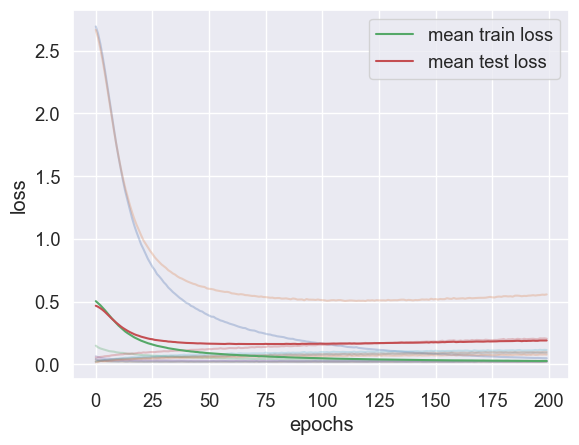

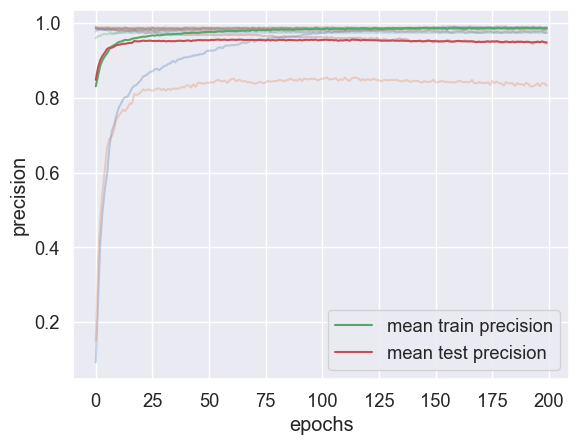

In [27]:


train_losses, test_losses, train_precisions, test_precisions, model = cross_validation(200, MLP,X, y, k=6, lr = 0.0003,hidden_size=32, input_size=vector_size,batch_size=32)

plt.figure()
affichage(train_losses, test_losses, train_precisions, test_precisions)

In [28]:
# calculate accuracy
from sklearn.metrics import accuracy_score
precision = accuracy_score(y, model(torch.Tensor(X)).argmax(dim=1).numpy())
print(f'Precision: {precision}')


Precision: 0.9880268199233716


In [29]:
# calculate accuracy
from sklearn.metrics import accuracy_score
precision = accuracy_score(y_test, model(torch.Tensor(X_test)).argmax(dim=1).numpy())
print(f'Precision: {precision}')


Precision: 0.8432122370936902


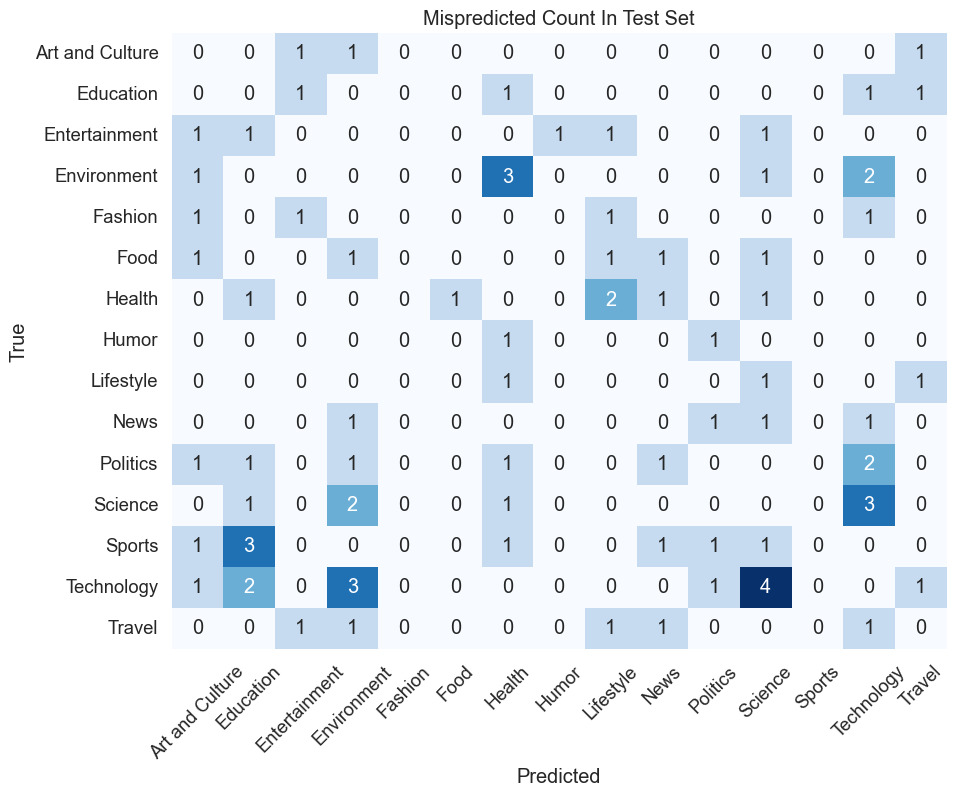

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = np.zeros((15, 15))
conf_matrix += confusion_matrix(y_test, model(torch.tensor(X_test).float()).argmax(dim=1).numpy())

conf_matrix = conf_matrix.astype('float') 
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count In Test Set')
plt.xticks(rotation=45)
plt.savefig("image/MLP Test Mispredicted")
plt.show()


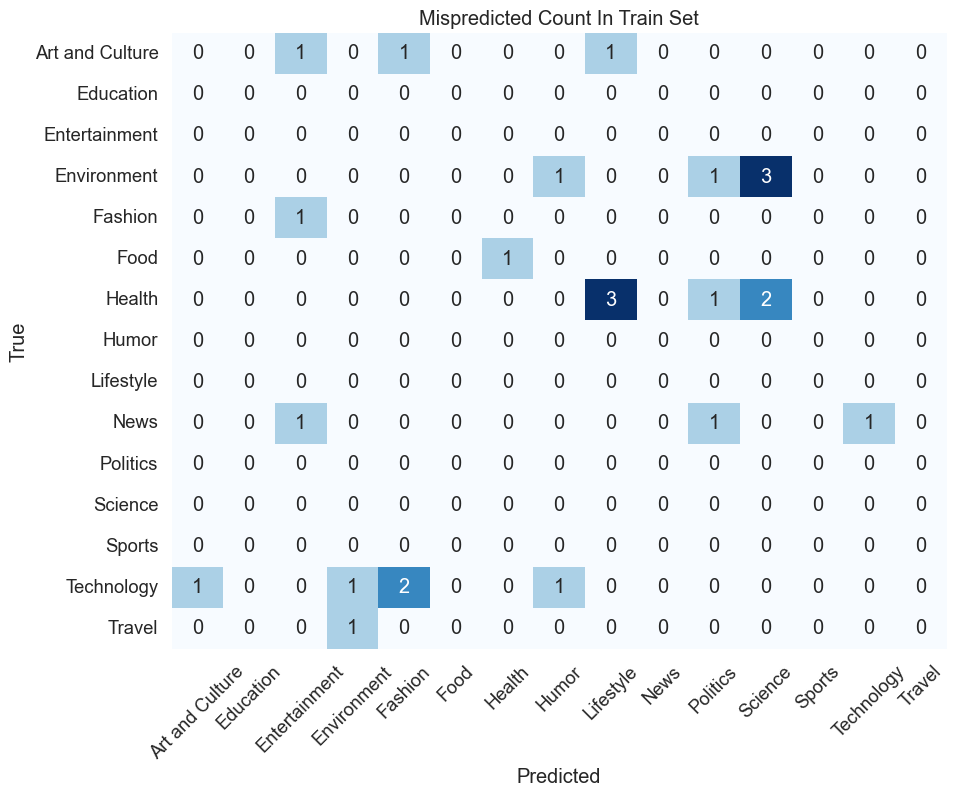

In [33]:
conf_matrix = np.zeros((15, 15))
conf_matrix += confusion_matrix(y, model(torch.tensor(X).float()).argmax(dim=1).numpy())

conf_matrix = conf_matrix.astype('float') 
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count In Train Set')
plt.xticks(rotation=45)
plt.savefig("MLP Mispredicted")
plt.show()

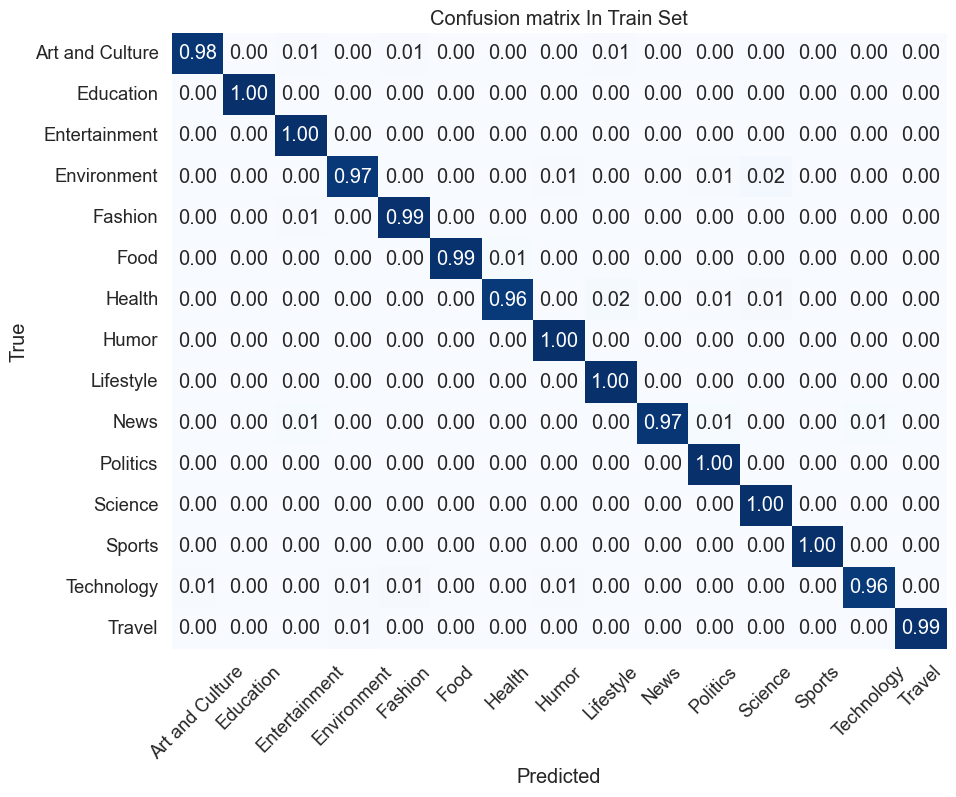

In [34]:
conf_matrix = np.zeros((15, 15))
conf_matrix += confusion_matrix(y, model(torch.tensor(X).float()).argmax(dim=1).numpy())

# 将混淆矩阵进行归一化
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True,fmt=".2f", cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix In Train Set')
plt.xticks(rotation=45)
plt.savefig("image/Train MLP CM")
plt.show()

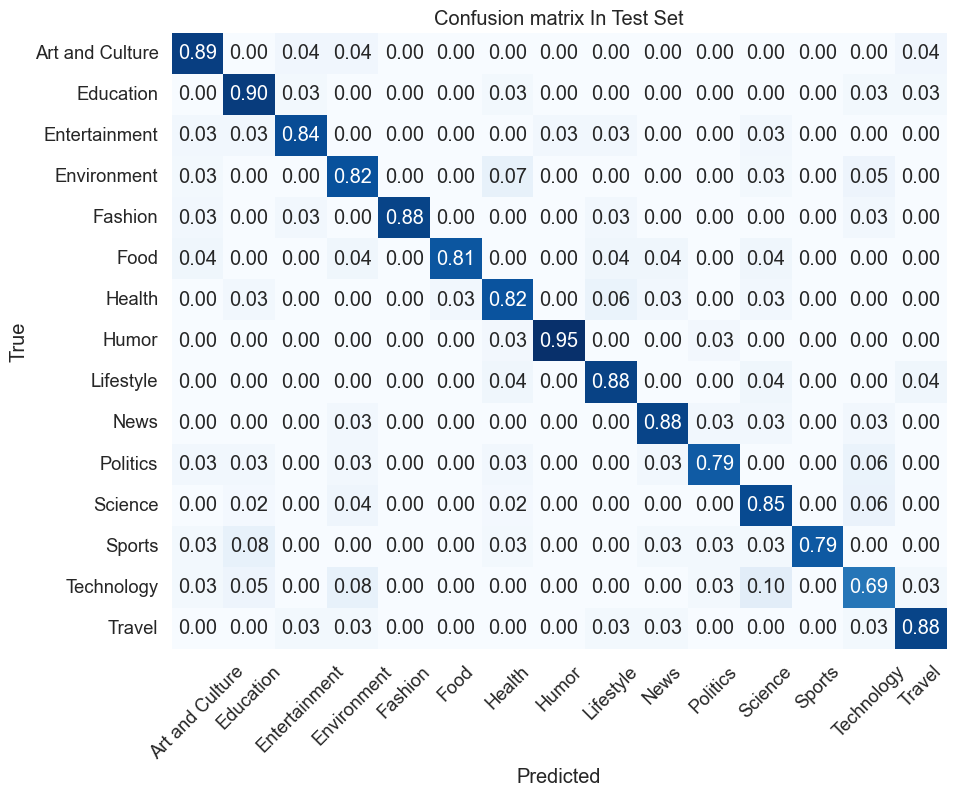

In [35]:
conf_matrix = np.zeros((15, 15))
conf_matrix += confusion_matrix(y_test, model(torch.tensor(X_test).float()).argmax(dim=1).numpy())

# 将混淆矩阵进行归一化
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True,fmt=".2f", cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix In Test Set')
plt.xticks(rotation=45)
plt.savefig("image/Test MLP CM")
plt.show()

In [33]:
label_encoder.classes_

array(['Art and Culture', 'Education', 'Entertainment', 'Environment',
       'Fashion', 'Food', 'Health', 'Humor', 'Lifestyle', 'News',
       'Politics', 'Science', 'Sports', 'Technology', 'Travel'],
      dtype='<U15')

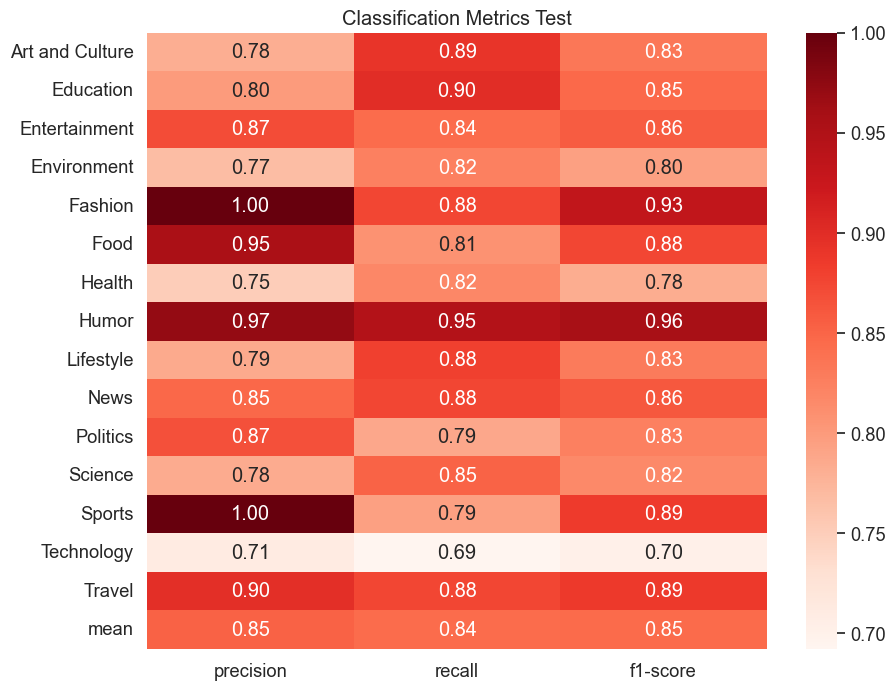

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Calculate precision, recall, and f1-score for each category
precision = np.zeros(15)
recall = np.zeros(15)
f1 = np.zeros(15)


res = precision_recall_fscore_support(y_test, model(torch.tensor(X_test).float()).argmax(dim=1).numpy())
precision += res[0]
recall += res[1]
f1 += res[2]


precision_mean = precision.mean()
recall_mean = recall.mean()
f1_mean = f1.mean()

precision = np.append(precision, precision_mean)
recall = np.append(recall, recall_mean)
f1 = np.append(f1, f1_mean)

# Calculate accuracy
accuracy = np.diag(f1).sum() / f1.sum()

# Combine the metrics into a single 2D array
metrics = np.array([precision, recall, f1]).T

# Assuming you have category names in the same order as the labels

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap='Reds',
            xticklabels=['precision', 'recall', 'f1-score'], 
            yticklabels=np.append(label_encoder.classes_,'mean'))
plt.title('Classification Metrics Test')
plt.savefig("image/MLP Metrics")
plt.show()


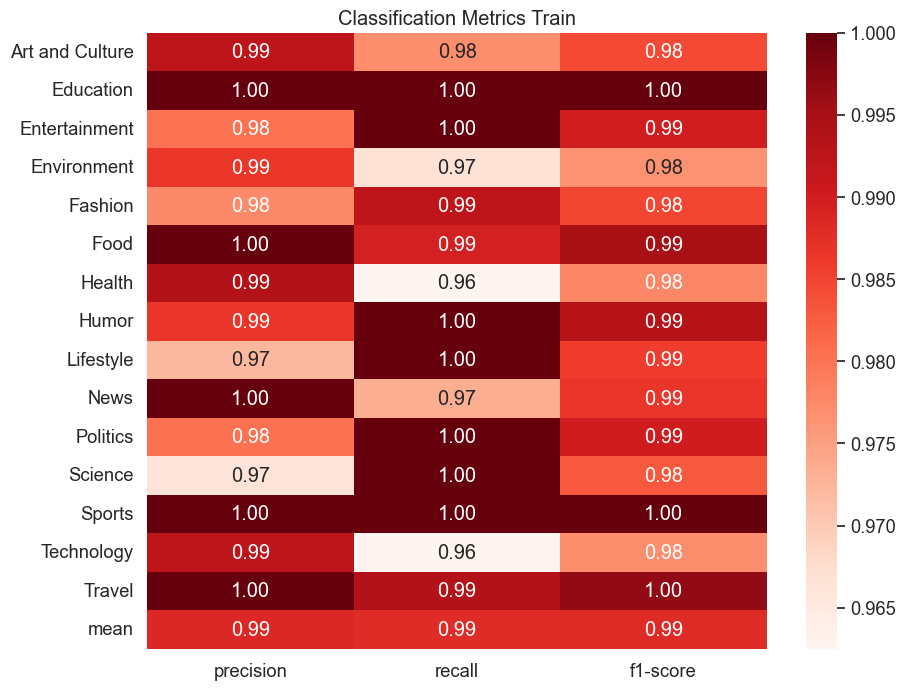

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Calculate precision, recall, and f1-score for each category
precision = np.zeros(15)
recall = np.zeros(15)
f1 = np.zeros(15)

res = precision_recall_fscore_support(y, model(torch.tensor(X).float()).argmax(dim=1).numpy())
precision += res[0]
recall += res[1]
f1 += res[2]


precision_mean = precision.mean()
recall_mean = recall.mean()
f1_mean = f1.mean()

precision = np.append(precision, precision_mean)
recall = np.append(recall, recall_mean)
f1 = np.append(f1, f1_mean)

# Calculate accuracy
accuracy = np.diag(f1).sum() / f1.sum()

# Combine the metrics into a single 2D array
metrics = np.array([precision, recall, f1]).T

# Assuming you have category names in the same order as the labels

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap='Reds',
            xticklabels=['precision', 'recall', 'f1-score'], 
            yticklabels=np.append(label_encoder.classes_,'mean'))
plt.title('Classification Metrics Train')
plt.savefig("image/MLP Train Metrics")
plt.show()
